## To Do
- try to combine line plot and heatmap (overlaid) + replace passes/likes by total AND add messages ?
- work with (app opens and) messages
- compare messages sent vs received
- finalize what I want to viz -> MAX 4 viz (includes triple heatmap)
- switch from df.plot -> seaborn
- do the river flow chart?

## Custom functions

In [279]:
def replace_zeros_inf(df):
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], 0)
    return df

def mask_max_min_vals(df, col):
    top_n_values = df[col].nlargest(1)
    bot_n_values = df[col].nsmallest(1)
    mask = df[col].apply(lambda x: x if x in top_n_values.values or x in bot_n_values.values else "")
    return mask.to_frame().T

def mask_top_n_vals(df, col, n):
    top_n_values = df[col].nlargest(n)
    mask = df[col].apply(lambda x: x if x in top_n_values.values else "")
    return mask.to_frame().T

# Reading data

In [280]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
plt.close("all")

In [281]:
#Ref: https://medium.com/analytics-vidhya/tinder-data-54ba494e0a59
f = open('Data/myData/data.json', 'r', encoding="utf8")
data = json.load(f)["Usage"]

df = pd.DataFrame.from_dict(data)
print(df)
df.describe()

            app_opens  swipes_likes  swipes_passes  superlikes  matches  \
2022-11-19         33             4            394           0        1   
2022-11-20         15            14            714           0        0   
2022-11-21          7             2             36           0        0   
2022-11-22          4             2             51           0        1   
2022-11-23          5             1             23           0        2   
...               ...           ...            ...         ...      ...   
2023-09-18          5             1             26           0        0   
2023-09-19         12             0             52           0        0   
2023-09-20          4             0              0           0        0   
2023-09-21         10             1             57           0        0   
2023-09-22          8             2             38           0        1   

            messages_sent  messages_received advertising_id idfa  
2022-11-19              2       

,app_opens,swipes_likes,swipes_passes,superlikes,matches,messages_sent,messages_received
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,7.354167,1.833333,80.677083,0.010417,0.552083,1.786458,1.822917
std,6.467768,2.862162,137.262503,0.101795,0.829682,5.634711,6.507337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.000000,38.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,82.250000,0.000000,1.000000,2.000000,1.000000
max,40.000000,15.000000,1152.000000,1.000000,5.000000,64.000000,79.000000


# Wrangling

In [282]:
df.index.name = "Date"
df = df.sort_values(["swipes_passes"], ascending = False)
if "superlikes" in df.columns:
    df = df.drop(["superlikes", "advertising_id", "idfa"], axis = 1)


df.index = pd.to_datetime(df.index)
df = df.sort_values(by='Date')


#fill in missing dates
all_dates = pd.date_range(start='2022-11-19', end='2023-09-22', freq='D')
df = df.reindex(all_dates, fill_value=0)

df["swipes_likes_no_match"] = df["swipes_likes"] - df["matches"]
df["matches_cumsum"] = df["matches"].cumsum()
df = replace_zeros_inf(df)

#WEEKLY STATS
df_passes_weekly = df.resample("W-MON").sum()

# df_passes_weekly = df_passes_weekly.drop("matches_cumsum")
df_passes_weekly["matches_cumsum"] = df_passes_weekly["matches"].cumsum()

df_passes_weekly["matches_like_pct"] = 100*df_passes_weekly["matches"] / df_passes_weekly["swipes_likes"] 
df_passes_weekly = replace_zeros_inf(df_passes_weekly)



#MONTHLY STATS
df_passes_matches_monthly = df.resample("MS").sum()
# df_passes_matches_monthly_scaled = df_passes_matches_monthly_scaled.drop(df_passes_matches_monthly_scaled.index[0])

# df_passes_matches_monthly_scaled = df_passes_matches_monthly_scaled.drop("matches_cumsum")
df_passes_matches_monthly["matches_cumsum"] = df_passes_matches_monthly["matches"].cumsum()
df_passes_matches_monthly = replace_zeros_inf(df_passes_matches_monthly)

df_passes_matches_monthly_scaled = df_passes_matches_monthly.copy()

nb_passes_matches = (df_passes_matches_monthly_scaled["swipes_likes"]  + df_passes_matches_monthly_scaled["swipes_passes"] )

df_passes_matches_monthly_scaled["matches_like_pct"] = 100*df_passes_matches_monthly_scaled["matches"] / df_passes_matches_monthly_scaled["swipes_likes"] 
df_passes_matches_monthly_scaled["swipes_passes"] = 100*df_passes_matches_monthly_scaled["swipes_passes"] / nb_passes_matches
df_passes_matches_monthly_scaled["swipes_likes_no_match"] = 100*df_passes_matches_monthly_scaled["swipes_likes_no_match"] / nb_passes_matches
df_passes_matches_monthly_scaled["matches"] = 100*df_passes_matches_monthly_scaled["matches"] / nb_passes_matches
df_passes_matches_monthly_scaled = replace_zeros_inf(df_passes_matches_monthly_scaled)

# df_likes_matches_monthly_scaled = df_passes_weekly.resample("MS").sum()

# nb_likes_matches = (df_likes_matches_monthly_scaled["matches"] + df_likes_matches_monthly_scaled["swipes_likes"])

# df_likes_matches_monthly_scaled["swipes_likes"] = 100*df_likes_matches_monthly_scaled["swipes_likes"] / nb_likes_matches
# df_likes_matches_monthly_scaled["matches"] = 100*df_likes_matches_monthly_scaled["matches"] / nb_likes_matches


# df.head(100)
# df_passes_weekly.head()
# df = df.describe()
print(df_passes_matches_monthly)

            app_opens  swipes_likes  swipes_passes  matches  messages_sent  \
2022-11-01         83            23           1282        4              2   
2022-12-01        177            43           1591       19            109   
2023-01-01        146            37            954       10             35   
2023-02-01        157            33           2078       11             11   
2023-03-01        194            39           2209       11             40   
2023-04-01        232            55           1710       16             74   
2023-05-01        110            49           1377       10             18   
2023-06-01         19            13            754        5              3   
2023-07-01         23            18            975        3              0   
2023-08-01        101            28           1064       11             28   
2023-09-01        170            14           1496        6             23   

            messages_received  swipes_likes_no_match  matches_c

# Visualization

### Line plots

<AxesSubplot:title={'center':'match pct per month'}>

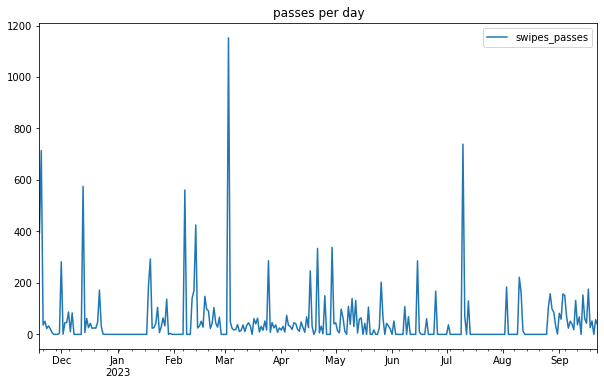

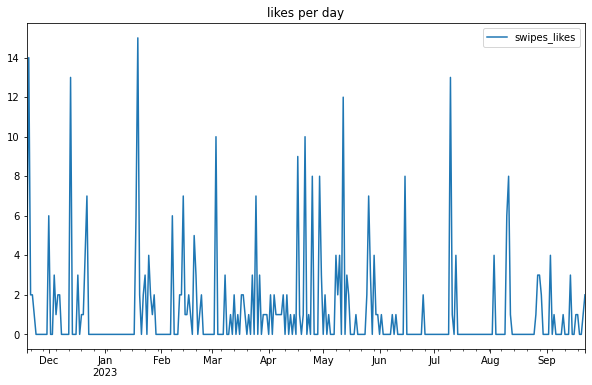

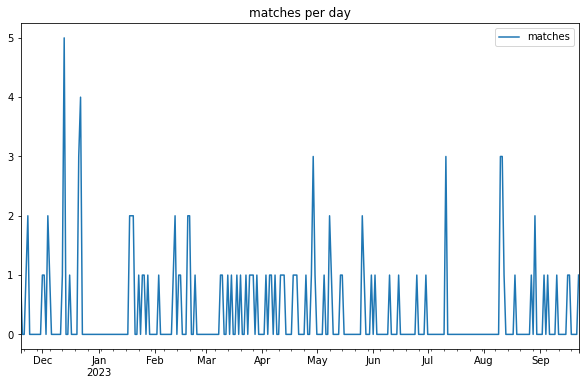

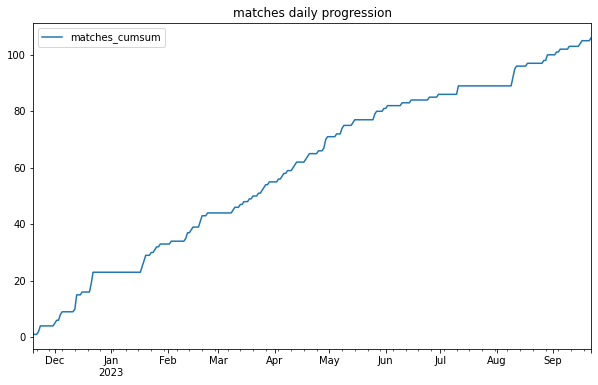

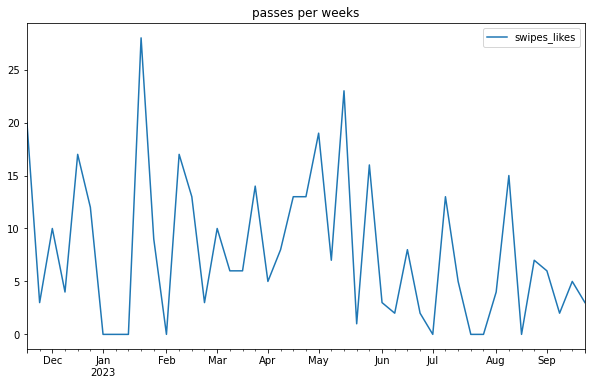

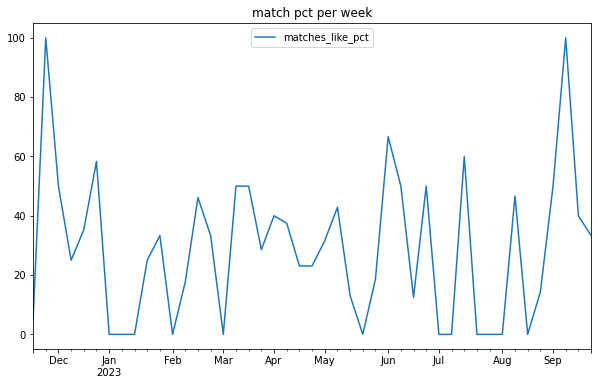

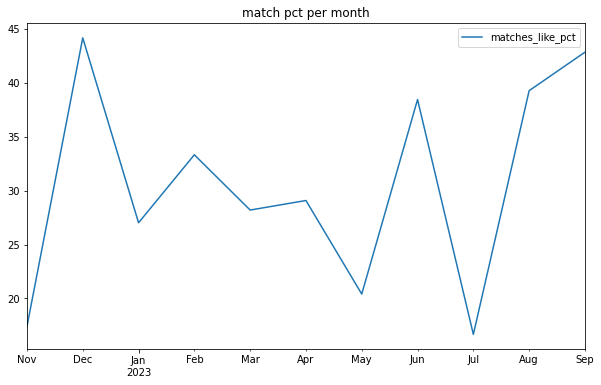

In [283]:
#passes per day
df.plot(y = "swipes_passes", figsize=(10, 6), title = "passes per day")
#likes per day
df.plot(y = "swipes_likes", figsize=(10, 6), title = "likes per day")
#matches per day
df.plot(y = "matches", figsize=(10, 6), title = "matches per day") #bad
#matches daily progression
df.plot(y = "matches_cumsum", figsize=(10, 6), title = "matches daily progression") 
#passes per weeks
df_passes_weekly.plot(y = "swipes_likes", figsize=(10, 6), title = "passes per weeks")

#match pct weeks
df_passes_weekly.plot(y = "matches_like_pct", figsize=(10, 6), title = "match pct per week")

#match pct month
df_passes_matches_monthly_scaled.plot(y = "matches_like_pct", figsize=(10, 6), title = "match pct per month")

### Scatter plots

<AxesSubplot:title={'center':'swipe passes vs matches'}, xlabel='swipes_passes', ylabel='matches'>

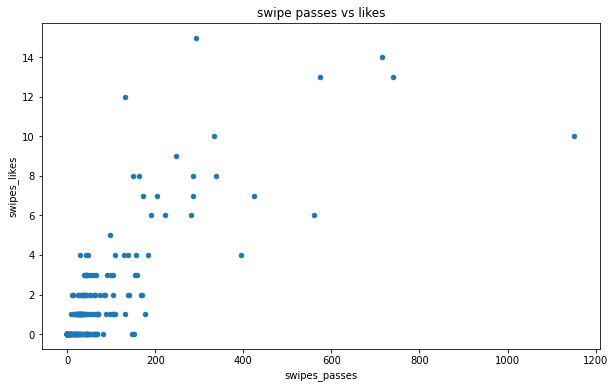

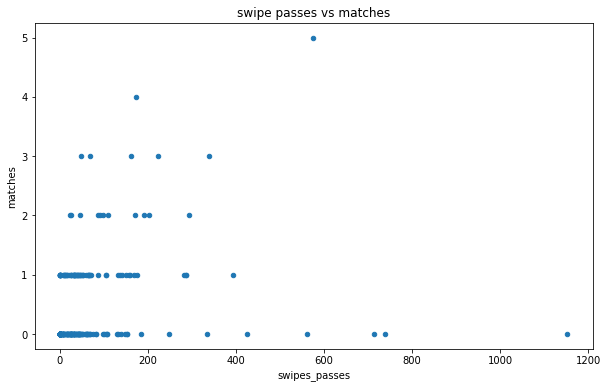

In [284]:
#swipe passes vs swipe likes
df.plot.scatter(x = "swipes_passes", y = "swipes_likes", figsize=(10, 6), title = "swipe passes vs likes") #bad
#swipe passes vs matches
df.plot.scatter(x = "swipes_passes", y = "matches", figsize=(10, 6), title = "swipe passes vs matches") 

### Histograms

array([[<AxesSubplot:xlabel='app_opens', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='app_opens'>,
        <AxesSubplot:xlabel='matches', ylabel='app_opens'>,
        <AxesSubplot:xlabel='messages_sent', ylabel='app_opens'>,
        <AxesSubplot:xlabel='messages_received', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_likes_no_match', ylabel='app_opens'>,
        <AxesSubplot:xlabel='matches_cumsum', ylabel='app_opens'>],
       [<AxesSubplot:xlabel='app_opens', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='matches', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='messages_sent', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='messages_received', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_likes_no_match', ylabel='s

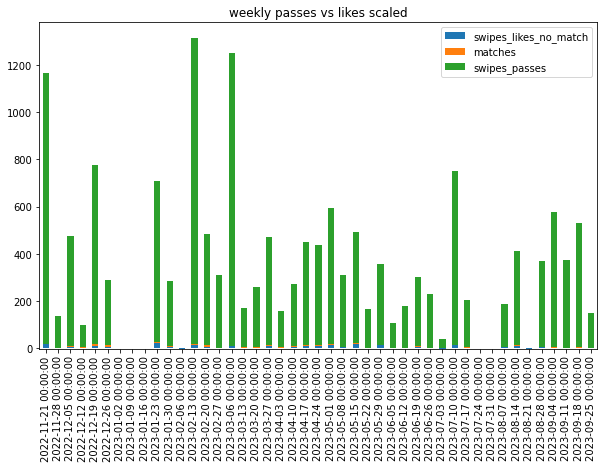

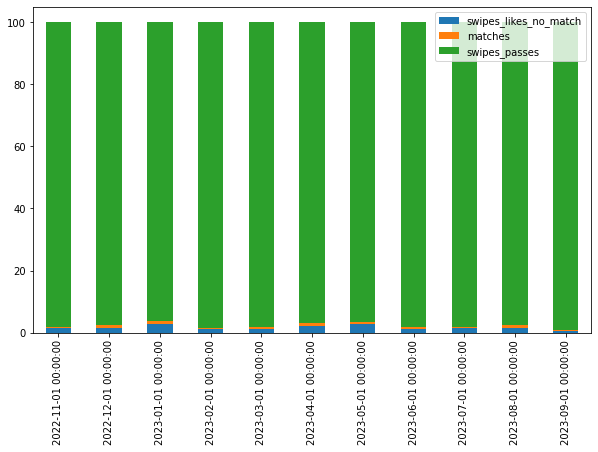

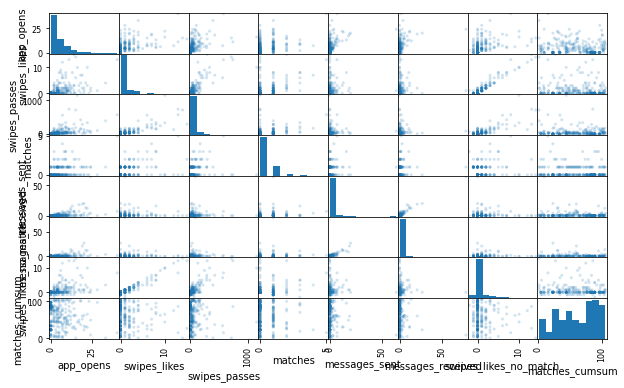

In [285]:
#weekly passes + matches bar
df_passes_weekly.plot.bar(y = ["swipes_likes_no_match", "matches", "swipes_passes"], stacked = True, figsize=(10, 6), title = "weekly passes vs likes scaled")

# #monthly likes + matches bar scaled to 100 AKA success rate
# df_likes_matches_monthly_scaled.plot.bar(y = ["matches", "swipes_likes"], stacked = True, figsize=(20,10))

#monthly passes + matches bar scaled to 100
df_passes_matches_monthly_scaled.plot.bar(y = ["swipes_likes_no_match", "matches", "swipes_passes"], stacked = True, figsize=(10, 6))
pd.plotting.scatter_matrix(df, alpha = .2, figsize=(10, 6))

### Heatmap

<Figure size 720x432 with 0 Axes>

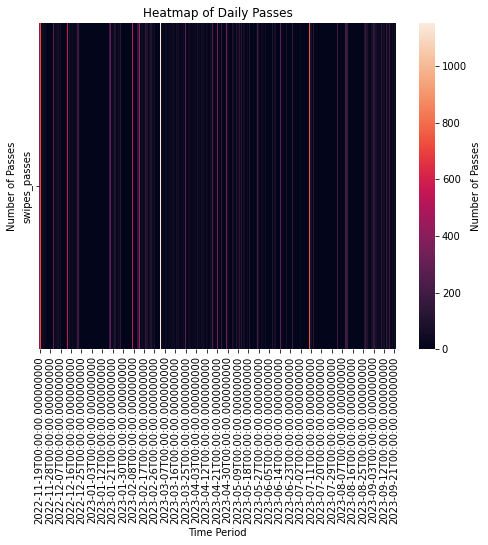

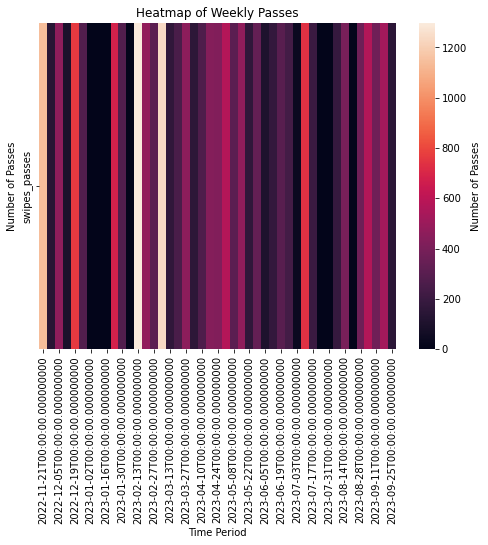

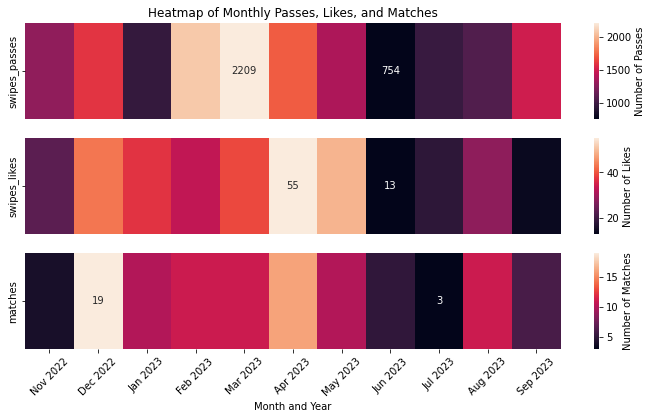

In [286]:
plt.figure(figsize=(10, 6))

#passes heatmap daily
# mean_value = df['swipes_passes'].mean()
# df_normalized = 2 * (df['swipes_passes'] - mean_value) / (df['swipes_passes'].max() - df['swipes_passes'].min())
# df_normalized.to_frame().T

plt.figure(figsize=(8, 6))
sns.heatmap(df[["swipes_passes"]].T, annot=False, fmt='d', cbar_kws={'label': 'Number of Passes'})
sns.color_palette("rocket", as_cmap=True)
plt.title('Heatmap of Daily Passes')
plt.xlabel('Time Period')
plt.ylabel('Number of Passes')
plt.show()



#passes heatmap weekly

plt.figure(figsize=(8, 6))
sns.heatmap(df_passes_weekly[["swipes_passes"]].T, annot=False, fmt='d', cbar_kws={'label': 'Number of Passes'})
sns.color_palette("rocket", as_cmap=True)
plt.title('Heatmap of Weekly Passes')
plt.xlabel('Time Period')
plt.ylabel('Number of Passes')
plt.show()

#passes heatmap monthly
# df_passes_matches_monthly_pct = df_passes_matches_monthly.copy()
# sum = df_passes_matches_monthly_pct['swipes_passes'].sum()
# df_passes_matches_monthly_pct['swipes_passes'] = 100*df_passes_matches_monthly_pct['swipes_passes']/sum
# sum = df_passes_matches_monthly_pct['swipes_likes'].sum()
# df_passes_matches_monthly_pct['swipes_likes'] = 100*df_passes_matches_monthly_pct['swipes_likes']/sum

# Sort the values in the column and select the top 10

fig, axes = plt.subplots(3, 1, figsize=(12, 6))

sns.heatmap(df_passes_matches_monthly[["swipes_passes"]].T, ax = axes[0], annot=mask_max_min_vals(df_passes_matches_monthly, "swipes_passes"), fmt='', cbar_kws={'label': 'Number of Passes'})
sns.heatmap(df_passes_matches_monthly[["swipes_likes"]].T, ax = axes[1], annot=mask_max_min_vals(df_passes_matches_monthly, "swipes_likes"), fmt='', cbar_kws={'label': 'Number of Likes'})
sns.heatmap(df_passes_matches_monthly[["matches"]].T, ax = axes[2], annot=mask_max_min_vals(df_passes_matches_monthly, "matches"), fmt='', cbar_kws={'label': 'Number of Matches'})
sns.color_palette("rocket", as_cmap=True)

axes[0].xaxis.set_visible(False)
axes[1].xaxis.set_visible(False)

axes[0].set_title('Heatmap of Monthly Passes, Likes, and Matches')
# axes[1].set_title('Heatmap of Monthly Likes')
# axes[2].set_title('Heatmap of Monthly Matches')

# axes[2].xaxis.set_major_locator(MonthLocator(interval=1))
# axes[2].xaxis.set_major_formatter(DateFormatter('%b'))
date_format = df_passes_matches_monthly.index.strftime('%b %Y')
axes[2].set_xticklabels(date_format, rotation=45)


plt.xlabel('Month and Year')
plt.xticks(rotation=45)
# plt.ylabel('Number of Passes')
plt.show()

## ChatGPT Testing

In [287]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data (replace this with your own data)
# data = {'swipes_passes': [2, 8, 9, 12, 2, 3]}
# df = pd.DataFrame(data)

# # Sort the values in the column and select the top 10
# top_n_values = df['swipes_passes'].nlargest(3)

# # Create a mask to annotate only the top 10 values
# mask = df['swipes_passes'].apply(lambda x: x if x in top_n_values.values else "")

# # Create a heatmap with the column as the y-variable
# plt.figure(figsize=(8, 6))
# sns.heatmap(df[['swipes_passes']].T, annot=mask.to_frame().T, fmt='', cmap='RdYlGn', cbar_kws={'label': 'Number of Passes'})
# plt.title('Heatmap of Top 10 Passes')
# plt.xlabel('Time Period')
# plt.ylabel('Number of Passes')
# plt.show()


# # Sample data (replace this with your own data)
# data = {'swipes_passes': [2, 8, 9, 12, 2, 3]}
# df = pd.DataFrame(data)

# # Calculate the mean of the column
# mean_value = df['swipes_passes'].mean()

# # Scale the data to have values from -1 to 1 with the mean as 0
# scaled_data = 2 * (df['swipes_passes'] - mean_value) / (df['swipes_passes'].max() - df['swipes_passes'].min())

# # Create a heatmap with the scaled column
# plt.figure(figsize=(8, 6))
# sns.heatmap(scaled_data.to_frame().T, annot=True, fmt='.2f', cmap='RdYlGn', cbar_kws={'label': 'Scaled Values'})
# plt.title('Heatmap with Values Scaled from -1 to 1 (Mean 0)')
# plt.xlabel('Time Period')
# plt.ylabel('Scaled Values')
# plt.show()

# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample data (replace this with your own data)
# data = {'swipes_passes': [2, 8, 9, 12, 2, 3],
#         'swipes_likes_no_match': [5, 10, 15, 20, 25, 30]}

# df_passes_matches_monthly = pd.DataFrame(data)

# fig, ax = plt.subplots(figsize=(12, 6))

# # Create a single heatmap for both columns
# sns.heatmap(df_passes_matches_monthly[['swipes_passes', 'swipes_likes_no_match']].T, ax=ax, annot=False, fmt='d', cbar_kws={'label': 'Value'})

# ax.set_title('Heatmap of Monthly Data')
# ax.set_xlabel('Time Period')
# ax.set_ylabel('Columns')

# plt.show()
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.dates import MonthLocator, DateFormatter

# # Sample data with a datetime index
# data = {'Value': [10, 20, 15, 30]}
# dates = pd.date_range(start='2023-01-01', periods=4, freq='M')

# df = pd.DataFrame(data, index=dates)

# # Create a line plot
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(df.index, df['Value'])

# # Set the x-axis locator and formatter to display month and year names
# ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Show every month
# ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

# plt.xlabel('Month and Year')
# plt.ylabel('Value')
# plt.title('Monthly Data')

# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# plt.show()


